In [1]:
## Name - Sheel Nidhan
## Date - 07 Jan, 2020
## This code coarse-grains the velocity field which can be used for further post-processing
# Check Yasuda and Vassilicos PRF 2019

In [2]:
import numpy as np
import matplotlib as ml
import matplotlib.pyplot as plt
import ioeddy as io 
import matplotlib.gridspec as gridspec
import pandas as pd
from scipy.ndimage import uniform_filter
from scipy.ndimage import gaussian_filter
from scipy.signal import medfilt

In [3]:
path='./'
filename = path + 'w_02635000.res'
i,j,k,it,time,dt,grav,data = io.readres(filename)

In [4]:
print('i,j,k=', i,j,k)
print('dtm=',dt)
print('grav=', grav)
print('size=',data.shape)
print('data=',data[1,2,5])
print('max_data=', np.nanmax(data))
print('min_data=', np.nanmin(data))
print('nstep=',it)

i,j,k= 366 258 4610
dtm= 0.0006914533758909792
grav= 0.0
size= (366, 258, 4610)
data= 0.9999900350997807
max_data= 1.7034594879374365
min_data= -1.3731562577376357
nstep= 2635000


In [5]:
nx, index, x, xe, xc = io.readgrid(path + 'x3_grid.in')
nr, index, r, re, rc = io.readgrid(path + 'x1_grid.in')
nth, index, th, the, thc = io.readgrid(path + 'x2_grid.in')

In [6]:
## Debug block 

In [7]:
xedges = thc
xedges[0]=0
yedges = rc[1:-1]
X,Y =np.meshgrid(xedges, yedges)

In [8]:
# Fixing the azimuthal gap by interpolation
data_ng = data[1:-1,:,1:-1]
data_ng[:,0,:] = 0.5*(data_ng[:,1,:]+data_ng[:,-2,:])
data_ng[:,-1,:] = data_ng[:,0,:]
data = None
data_slice = data_ng[:,:,io.loc(xc,0)]
#data_slice = data_ng[:,:,-1]

In [9]:
## Debug block

print(np.shape(data_ng))

(364, 258, 4608)


In [10]:
xedges = xc[1:-1]
#xedges[0]=0
rcng=rc[1:-1];
yedges2 = np.concatenate((-rcng[::-1],rcng),axis=0)
#yedges=yedges[1:-1]
X2,Y2 =np.meshgrid(xedges, yedges2)


In [11]:
## Axial slices

data_slice_2 = data_ng[:,127,:]
data_slice_3 = data_ng[:,255,:]
data_slice_4 =np.concatenate((np.flip(data_slice_3,axis=0),data_slice_2),axis=0)

In [12]:
## Debug block

print(np.shape(data_slice_4))

(728, 4608)


In [13]:
df_X2 = pd.DataFrame(X2,    index=yedges2, columns=xedges)
df_Y2 = pd.DataFrame(Y2,    index=yedges2, columns=xedges)
df_U2 = pd.DataFrame(data_slice_4, index=yedges2, columns=xedges)

xmin = 0
xmax = 30
ymin = 0
ymax = 5

roi2 = (-3 <= df_X2) & (df_X2 <= 30) & (-5 <= df_Y2) & (df_Y2 <= 5)

df_X2_crop = df_X2[roi2].dropna(axis=[0,1], how='all')
df_Y2_crop = df_Y2[roi2].dropna(axis=[0,1], how='all')
df_U2_crop = df_U2[roi2].dropna(axis=[0,1], how='all')

/home/sheel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: supplying multiple axes to axis is deprecated and will be removed in a future version.
  if sys.path[0] == '':
/home/sheel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: FutureWarning: supplying multiple axes to axis is deprecated and will be removed in a future version.
  del sys.path[0]
/home/sheel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: supplying multiple axes to axis is deprecated and will be removed in a future version.
  


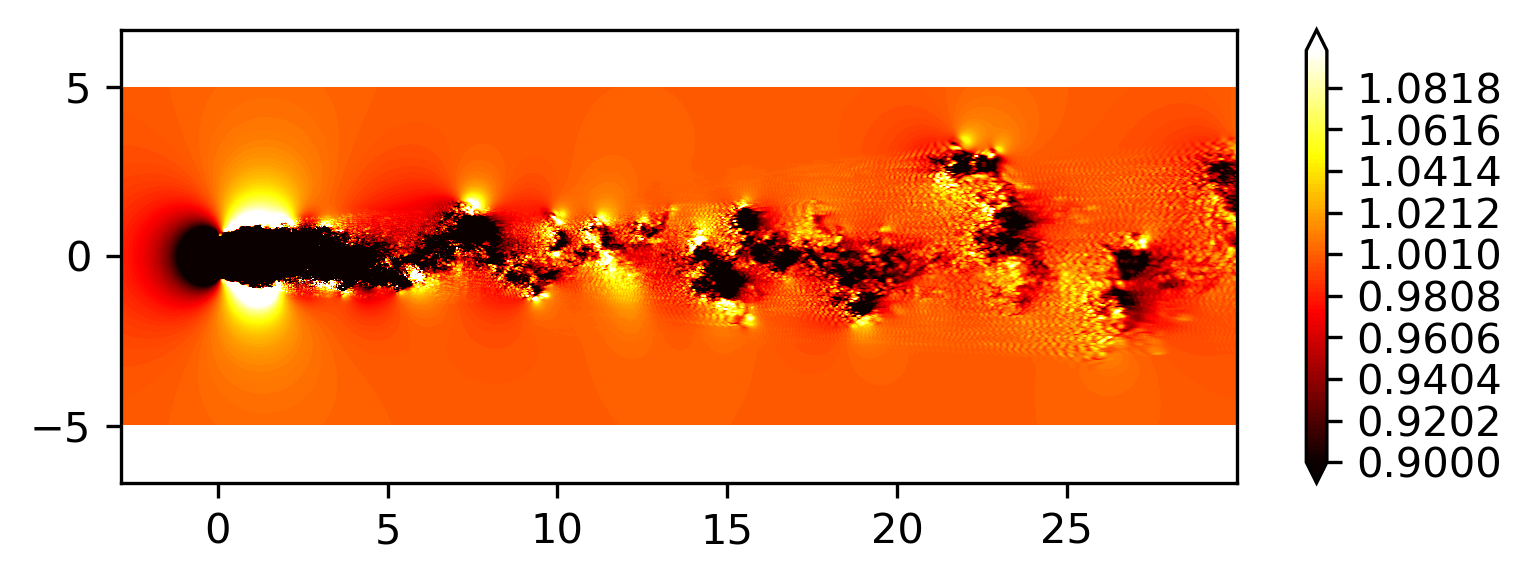

In [14]:
fig2 = plt.figure(figsize=(6,2), dpi=300)
gsp2 = gridspec.GridSpec(1,1)
plt.subplot(gsp2[0,0])
lvls = np.linspace(0.9, 1.1, 100)

plt.contourf(df_X2_crop, df_Y2_crop, df_U2_crop,levels=lvls,cmap='hot',extend='both')
plt.axis('equal')

#plt.pcolormesh(df_X2_crop, df_Y2_crop, df_U2_crop,levels=lvls)
plt.colorbar()
plt.show()

In [15]:
## Starting the procedure of Gaussian filtering
## Step 1 - Centering the variable

# For axial velocity
data_filter = 0.5*(data_ng[:,:,1:] + data_ng[:,:,0:-1])
data_ng = None
## Has to implement of other velocity profiles

In [16]:
## Step 2 - Finding the correct xc grid
xc_filter = xc[2:-1]
rc_filter = rc[1:-1]

dxc_filter = xe[2:-1] - xe[1:-2]
drc_filter = re[1:-1] - re[0:-2] 

In [17]:
## Debug block

print('Shape of data_filter = ',   np.shape(data_filter))
print('Shape of xc_filter = ', np.shape(xc_filter))
print('Shape of rc_filter = ', np.shape(rc_filter))
print('Shape of dxc_filter = ', np.shape(dxc_filter))
print('Shape of drc_filter = ', np.shape(drc_filter))
print('Minimum of data_filter =',  np.amin(data_filter))
print('Maximum of data_filter = ', np.amax(data_filter))

Shape of data_filter =  (364, 258, 4607)
Shape of xc_filter =  (4607,)
Shape of rc_filter =  (364,)
Shape of dxc_filter =  (4607,)
Shape of drc_filter =  (364,)
Minimum of data_filter = -1.333316578903446
Maximum of data_filter =  1.6560517412239997


In [18]:
## Step 3 - Truncating the domain to subdomain

# Truncating the axial direction
v = 0.5
idx_start_x = (np.abs(xc_filter - v)).argmin()
v = 30
idx_end_x = (np.abs(xc_filter - v)).argmin()
xc_filter2 = xc_filter[idx_start_x:idx_end_x+1]
dxc_filter2 = xc_filter[idx_start_x:idx_end_x+1]

# Truncating the axial direction
v = 5
idx_end_r = (np.abs(rc_filter - v)).argmin()
rc_filter2 = rc_filter[0:idx_end_r+1]
drc_filter2 = drc_filter[0:idx_end_r+1]

data_filter2 = data_filter[0:idx_end_r+1,1:-1,idx_start_x:idx_end_x+1]

In [19]:
## Debug block

print('idx_start_x = ', idx_start_x)
print('idx_end_x = ', idx_end_x)
print('idx_end_r = ', idx_end_r)
print('Shape of xc_filter2 = ', np.shape(xc_filter2))
print('Shape of rc_filter2 = ', np.shape(rc_filter2))
print('Shape of dxc_filter2 = ', np.shape(dxc_filter2))
print('Shape of drc_filter2 = ', np.shape(drc_filter2))
print('Shape of data_filter2 = ', np.shape(data_filter2))
print(xc_filter2[0])
print(xc_filter2[-1])
print(rc_filter2[0])
print(rc_filter2[-1])

idx_start_x =  469
idx_end_x =  2267
idx_end_r =  255
Shape of xc_filter2 =  (1799,)
Shape of rc_filter2 =  (256,)
Shape of dxc_filter2 =  (1799,)
Shape of drc_filter2 =  (256,)
Shape of data_filter2 =  (256, 256, 1799)
0.4986460862891865
29.998489146188447
0.006756000220775605
5.0043460313589705


In [20]:
## Step 4 - Parameters of the 3D Gaussian filter

u_infty  = 1
frequency_cutoff = 0.5
lambda_cutoff = u_infty/frequency_cutoff
sigma = lambda_cutoff    # This may change later

In [21]:
## Step 5 - Gaussian filter at one location

# i = 128; j = 45; k = 500
# filtered_vel = uniform_filter(data_filter2, size=3, mode='constant')
filtered_vel = gaussian_filter(data_filter2, sigma = 2.5)

In [22]:
## Axial slices

data_slice_2 = filtered_vel[:,127,:]
data_slice_3 = filtered_vel[:,255,:]
data_slice_4 =np.concatenate((np.flip(data_slice_3,axis=0),data_slice_2),axis=0)

In [23]:
# Debug block

print(np.shape(data_slice_4))

(512, 1799)


In [24]:
xedges = xc_filter2
#xedges[0]=0
rcng=rc_filter2;
yedges2 = np.concatenate((-rcng[::-1],rcng),axis=0)
#yedges=yedges[1:-1]
X2,Y2 =np.meshgrid(xedges, yedges2)

In [25]:
## Step 6 - Plotting the filtered data
df_X2 = pd.DataFrame(X2,    index=yedges2, columns=xedges)
df_Y2 = pd.DataFrame(Y2,    index=yedges2, columns=xedges)
df_U2 = pd.DataFrame(data_slice_4, index=yedges2, columns=xedges)

xmin = 0
xmax = 30
ymin = 0
ymax = 5

roi2 = (-3 <= df_X2) & (df_X2 <= 30) & (-5 <= df_Y2) & (df_Y2 <= 5)

df_X2_crop = df_X2[roi2].dropna(axis=[0,1], how='all')
df_Y2_crop = df_Y2[roi2].dropna(axis=[0,1], how='all')
df_U2_crop = df_U2[roi2].dropna(axis=[0,1], how='all')


/home/sheel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: FutureWarning: supplying multiple axes to axis is deprecated and will be removed in a future version.
  del sys.path[0]
/home/sheel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: supplying multiple axes to axis is deprecated and will be removed in a future version.
  
/home/sheel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: FutureWarning: supplying multiple axes to axis is deprecated and will be removed in a future version.
  from ipykernel import kernelapp as app


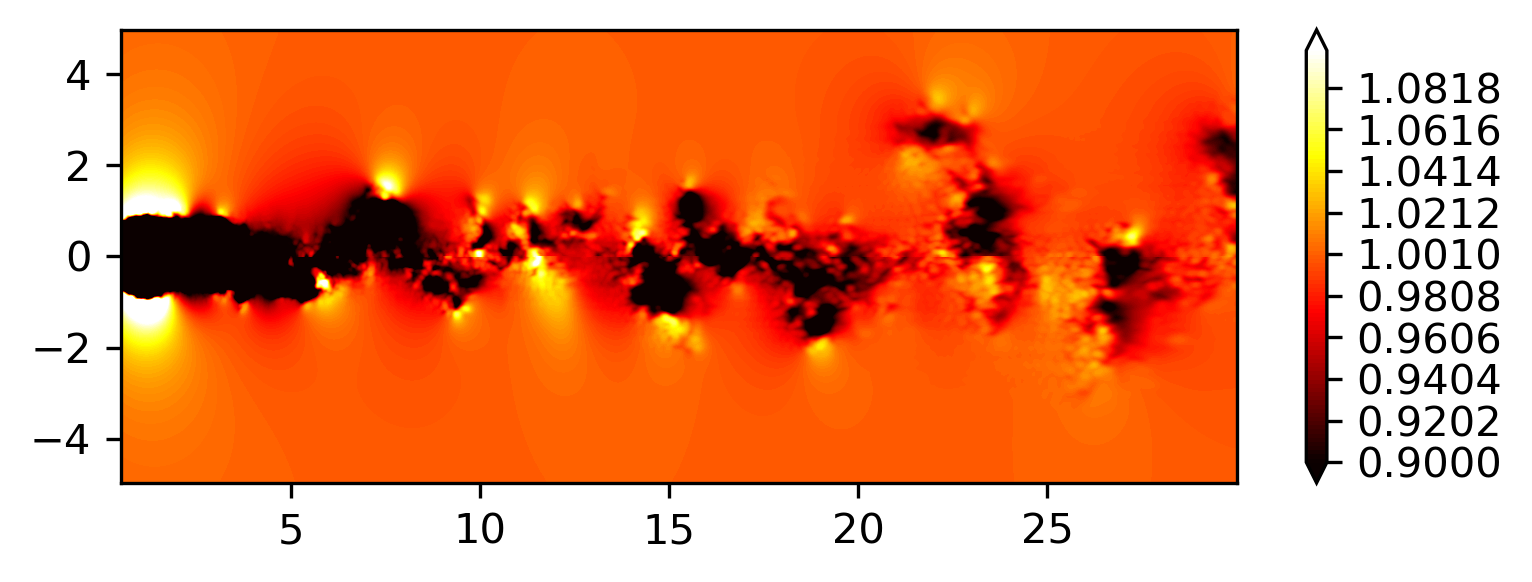

In [26]:
fig2 = plt.figure(figsize=(6,2), dpi=300)
gsp2 = gridspec.GridSpec(1,1)
plt.subplot(gsp2[0,0])
lvls = np.linspace(0.9, 1.1, 100)

plt.contourf(df_X2_crop, df_Y2_crop, df_U2_crop,levels=lvls,cmap='hot',extend='both')

plt.colorbar()
plt.show()